In [ ]:
#import libraries
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras.utils import to_categorical
import numpy as np
from sklearn.utils import resample
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt # Import the relevant module
from matplotlib import pyplot

In [ ]:
def load_fashion_mnsit_dataset():
  
  # example of loading the fashion mnist dataset  
  from matplotlib import pyplot
  from keras.datasets import fashion_mnist

  # load dataset
  (trainX, trainY), (testX, testY) = fashion_mnist.load_data()
  # summarize loaded dataset
  print('Train: X=%s, y=%s' % (trainX.shape, trainY.shape))
  print('Test: X=%s, y=%s' % (testX.shape, testY.shape))

  # reshape dataset to have a single channel
  trainX = trainX.reshape((trainX.shape[0], 28, 28, 1))
  testX = testX.reshape((testX.shape[0], 28, 28, 1))
  
  # one hot encode target values
  trainY = to_categorical(trainY)
  testY = to_categorical(testY)

  return (trainX, trainY), (testX, testY)



In [ ]:
#Set hyper-parameters for our training of neural networks
LEARNING_RATE = 0.001
EPOCH = 100
VERBOSE = 1

TRAINING_SIZE = 3000
TEST_SIZE = 2000

#No of target models
NUM_TARGET = 1 
#No of shadow models
NUM_SHADOW = 6

#Label value "in" for records present in training data of shadow models 
IN = 1
#Label value "out" for records not present in training data of shadow models 
OUT = 0

In [ ]:
def sample_data(train_data,test_data,num_sets):
    (x_train, y_train), (x_test, y_test) = train_data, test_data
    new_x_train, new_y_train = [], []
    new_x_test, new_y_test = [], []
    for i in range(num_sets):
        x_temp, y_temp = resample(x_train, y_train, n_samples=TRAINING_SIZE, random_state=0)
        new_x_train.append(x_temp)
        new_y_train.append(y_temp)
        x_temp, y_temp = resample(x_test, y_test, n_samples=TEST_SIZE, random_state=0)
        new_x_test.append(x_temp)
        new_y_test.append(y_temp)
    return (new_x_train, new_y_train), (new_x_test, new_y_test)

In [ ]:
def get_attack_dataset(models, train_data, test_data, num_models, data_size):
    # generate dataset for the attack model
    (x_train, y_train), (x_test, y_test) = train_data, test_data
    # set number of classes for the attack model
    num_classes = 10
    x_data, y_data = [[] for i in range(num_classes)], [[] for i in range(num_classes)]
    for i in range(num_models):
        # IN data
        x_temp, y_temp = resample(x_train[i], y_train[i], n_samples=data_size, random_state=0)

        #print(x_temp)
        #print(y_temp)
        #print(x_temp[0][0])

        for j in range(data_size):
            #print(j)
            y_idx = np.argmax(y_temp[j])
            x_data[y_idx].append(models[i].predict(x_temp[j:j+1])[0])
            #x_data[y_idx].append(models[i].predict(x_temp[j])[0])
            y_data[y_idx].append(IN)

        # OUT data
        x_temp, y_temp = resample(x_test[i], y_test[i], n_samples=data_size, random_state=0)

        #print(x_temp)
        #print(y_temp)

        for j in range(data_size):
            #print(j)
            y_idx = np.argmax(y_temp[j])
            x_data[y_idx].append(models[i].predict(x_temp[j:j+1])[0])
            #x_data[y_idx].append(models[i].predict(x_temp[j])[0])
            y_data[y_idx].append(OUT)
          
    return x_data, y_data

In [ ]:
def build_fcnn_model_fashion_mnist():
  from keras.models import Sequential
  from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
  model = tf.keras.models.Sequential([ 
  tf.keras.layers.Flatten(input_shape=(28, 28)), 
  tf.keras.layers.Dense(128, activation='relu'),    
  tf.keras.layers.Dense(10, activation='softmax')     
  ])
  model.summary()
  return model

In [ ]:
def get_trained_keras_models(keras_model, train_data, test_data, num_models):
    (x_train, y_train), (x_test, y_test) = train_data, test_data
    models = []
    for i in range(num_models):
        models.append(tensorflow.keras.models.clone_model(keras_model))
        rms = tensorflow.keras.optimizers.RMSprop(lr=LEARNING_RATE, decay=1e-7)
        models[i].compile(loss='binary_crossentropy', optimizer=rms, metrics=['accuracy'])
        models[i].fit(x_train[i], y_train[i], batch_size=32, epochs=EPOCH, verbose=VERBOSE, shuffle=True)
        score = models[i].evaluate(x_test[i], y_test[i], verbose=VERBOSE)
        print('\n', 'Model ', i, ' test accuracy:', score[1])
    return models

In [ ]:
def get_trained_svm_models(train_data, test_data, num_models=1):
    from sklearn import svm
    (x_train, y_train), (x_test, y_test) = train_data, test_data
    models = []
    for i in range(num_models):
        print('Training svm model : ', i)
        models.append(svm.SVC(gamma='scale',kernel='linear',verbose=VERBOSE))
        models[i].fit(x_train[i], y_train[i])
        score = models[i].score(x_test[i],y_test[i])
        print('SVM model ', i, 'score : ',score)
    return models

In [ ]:
def membership_attack():

  # load the pre-shuffled train and test data
  (x_train, y_train), (x_test, y_test) = load_fashion_mnsit_dataset()

  # split the data for each model
  target_train = (x_train[:TRAINING_SIZE*NUM_TARGET],y_train[:TRAINING_SIZE*NUM_TARGET])
  target_test = (x_test[:TEST_SIZE*NUM_TARGET],y_test[:TEST_SIZE*NUM_TARGET])
  target_train_data, target_test_data = sample_data(target_train, target_test, NUM_TARGET)

  shadow_train = (x_train[TRAINING_SIZE*NUM_TARGET:],y_train[TRAINING_SIZE*NUM_TARGET:])
  shadow_test = (x_test[TEST_SIZE*NUM_TARGET:],y_test[TEST_SIZE*NUM_TARGET:])
  shadow_train_data, shadow_test_data = sample_data(shadow_train, shadow_test, NUM_SHADOW)

  cnn_model = build_fcnn_model_fashion_mnist()  

  # compile the target model
  target_models = get_trained_keras_models(cnn_model, target_train_data, target_test_data, NUM_TARGET)
  # compile the shadow models
  shadow_models = get_trained_keras_models(cnn_model, shadow_train_data, shadow_test_data, NUM_SHADOW)

  # get train data for the attack model
  attack_train = get_attack_dataset(shadow_models, shadow_train_data, shadow_test_data, NUM_SHADOW, TEST_SIZE)
  # get test data for the attack model
  attack_test = get_attack_dataset(target_models, target_train_data, target_test_data, NUM_TARGET, TEST_SIZE)

  # training the attack model
  attack_model = get_trained_svm_models(attack_train, attack_test)

## Linear SVM as the Attack Model

### a) Training Size=3000

In [ ]:
#Train size=3000
#Test size=2000
accuracy= []
no_of_shadow_models=[]

linear_svm_accuracy_scores=[]

In [ ]:
NUM_SHADOW = 2
membership_attack()

Train: X=(60000, 28, 28), y=(60000,)
Test: X=(10000, 28, 28), y=(10000,)
Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_8 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_16 (Dense)             (None, 128)               100480    
_________________________________________________________________
dense_17 (Dense)             (None, 10)                1290      
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
94/94 [==============================] - 0s 1ms/step - loss: 9.5333 - accuracy: 0.5227
Epoch 2/100
94/94 [==============================] - 0s 1ms/step - loss: 1.5659 - accuracy: 0.7346
Epoch 3/100
94/94 [==============================] - 0s 1ms/step - loss: 1.0275 - accuracy: 0.7607
Epoch 4/

In [ ]:
accuracy.append(0.5913)
no_of_shadow_models.append(2)

In [ ]:
NUM_SHADOW = 3
membership_attack()

Train: X=(60000, 28, 28), y=(60000,)
Test: X=(10000, 28, 28), y=(10000,)
Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_7 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 128)               100480    
_________________________________________________________________
dense_15 (Dense)             (None, 10)                1290      
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
94/94 [==============================] - 0s 1ms/step - loss: 11.3021 - accuracy: 0.4627
Epoch 2/100
94/94 [==============================] - 0s 1ms/step - loss: 1.5916 - accuracy: 0.7217
Epoch 3/100
94/94 [==============================] - 0s 1ms/step - loss: 0.9967 - accuracy: 0.7735
Epoch 4

In [ ]:
accuracy.append(0.6102)
no_of_shadow_models.append(3)

In [ ]:
NUM_SHADOW = 4
membership_attack()

Train: X=(60000, 28, 28), y=(60000,)
Test: X=(10000, 28, 28), y=(10000,)
Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_6 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 128)               100480    
_________________________________________________________________
dense_13 (Dense)             (None, 10)                1290      
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
94/94 [==============================] - 0s 1ms/step - loss: 12.0256 - accuracy: 0.4903
Epoch 2/100
94/94 [==============================] - 0s 1ms/step - loss: 1.7843 - accuracy: 0.7256
Epoch 3/100
94/94 [==============================] - 0s 1ms/step - loss: 1.0314 - accuracy: 0.7751
Epoch 4

In [ ]:
accuracy.append(0.6021)
no_of_shadow_models.append(4)

linear_svm_accuracy_scores.append(0.6021)

In [ ]:
NUM_SHADOW = 5
membership_attack()

Train: X=(60000, 28, 28), y=(60000,)
Test: X=(10000, 28, 28), y=(10000,)
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               100480    
_________________________________________________________________
dense_5 (Dense)              (None, 10)                1290      
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
94/94 [==============================] - 0s 1ms/step - loss: 9.0763 - accuracy: 0.5055
Epoch 2/100
94/94 [==============================] - 0s 1ms/step - loss: 1.9259 - accuracy: 0.7285
Epoch 3/100
94/94 [==============================] - 0s 1ms/step - loss: 0.9590 - accuracy: 0.7540
Epoch 4/

In [ ]:
accuracy.append(0.5913)
no_of_shadow_models.append(5)


linear_svm_accuracy_scores.append(0.5913)

In [ ]:
NUM_SHADOW = 6
membership_attack()

Train: X=(60000, 28, 28), y=(60000,)
Test: X=(10000, 28, 28), y=(10000,)
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               100480    
_________________________________________________________________
dense_3 (Dense)              (None, 10)                1290      
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
94/94 [==============================] - 0s 1ms/step - loss: 13.0695 - accuracy: 0.4866
Epoch 2/100
94/94 [==============================] - 0s 1ms/step - loss: 2.1419 - accuracy: 0.7221
Epoch 3/100
94/94 [==============================] - 0s 1ms/step - loss: 1.1374 - accuracy: 0.7742
Epoch 4

In [ ]:
accuracy.append(0.6370)
no_of_shadow_models.append(6)


linear_svm_accuracy_scores.append(0.6370)

In [ ]:
NUM_SHADOW = 7
membership_attack()

Train: X=(60000, 28, 28), y=(60000,)
Test: X=(10000, 28, 28), y=(10000,)
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_3 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 128)               100480    
_________________________________________________________________
dense_7 (Dense)              (None, 10)                1290      
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
94/94 [==============================] - 0s 1ms/step - loss: 9.6029 - accuracy: 0.4534
Epoch 2/100
94/94 [==============================] - 0s 1ms/step - loss: 1.4941 - accuracy: 0.7101
Epoch 3/100
94/94 [==============================] - 0s 1ms/step - loss: 0.8784 - accuracy: 0.7709
Epoch 4/

In [ ]:
accuracy.append(0.6129)
no_of_shadow_models.append(7)


linear_svm_accuracy_scores.append(0.6129)

In [ ]:
NUM_SHADOW = 8
membership_attack()

Train: X=(60000, 28, 28), y=(60000,)
Test: X=(10000, 28, 28), y=(10000,)
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_4 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 128)               100480    
_________________________________________________________________
dense_9 (Dense)              (None, 10)                1290      
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
94/94 [==============================] - 0s 1ms/step - loss: 12.3783 - accuracy: 0.4725
Epoch 2/100
94/94 [==============================] - 0s 988us/step - loss: 2.5437 - accuracy: 0.7306
Epoch 3/100
94/94 [==============================] - 0s 1ms/step - loss: 1.6891 - accuracy: 0.7815
Epoch

In [ ]:
accuracy.append(0.6102)
no_of_shadow_models.append(8)

In [ ]:
NUM_SHADOW = 9
membership_attack()

Train: X=(60000, 28, 28), y=(60000,)
Test: X=(10000, 28, 28), y=(10000,)
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_5 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 128)               100480    
_________________________________________________________________
dense_11 (Dense)             (None, 10)                1290      
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
94/94 [==============================] - 0s 1ms/step - loss: 10.3685 - accuracy: 0.4673
Epoch 2/100
94/94 [==============================] - 0s 995us/step - loss: 1.9371 - accuracy: 0.7319
Epoch 3/100
94/94 [==============================] - 0s 1ms/step - loss: 1.3095 - accuracy: 0.7745
Epoch

In [ ]:
accuracy.append(0.6344)
no_of_shadow_models.append(9)

In [ ]:
NUM_SHADOW = 10
membership_attack()

Train: X=(60000, 28, 28), y=(60000,)
Test: X=(10000, 28, 28), y=(10000,)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               100480    
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1290      
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
94/94 [==============================] - 1s 5ms/step - loss: 12.2935 - accuracy: 0.4880
Epoch 2/100
94/94 [==============================] - 0s 3ms/step - loss: 2.0645 - accuracy: 0.7554
Epoch 3/100
94/94 [==============================] - 0s 3ms/step - loss: 1.4807 - accuracy: 0.7599
Epoch 4/1

In [ ]:
accuracy.append(0.5967)
no_of_shadow_models.append(10)

In [ ]:
accuracy

[0.5913, 0.6102, 0.6021, 0.5913, 0.637, 0.6129, 0.6102, 0.6344]

In [ ]:
no_of_shadow_models

[2, 3, 4, 5, 6, 7, 8, 9]

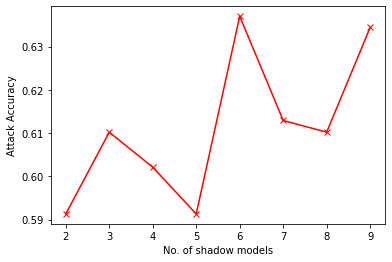

In [ ]:
import matplotlib.pyplot as plt

plt.plot(no_of_shadow_models, accuracy, 'r', marker = 'x') 
ax = plt.gca()
plt.xlabel("No. of shadow models")
plt.ylabel("Attack Accuracy")
plt.show()


### b) Training Size = 6000

In [ ]:
#CHANGING TRAINING SIZE

TRAINING_SIZE = 6000
TEST_SIZE = 2000

In [ ]:
accuracy2=[]
no_of_shadow_models2=[]

In [ ]:
NUM_SHADOW = 4
membership_attack()

Train: X=(60000, 28, 28), y=(60000,)
Test: X=(10000, 28, 28), y=(10000,)
Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_16 (Flatten)         (None, 784)               0         
_________________________________________________________________
dense_32 (Dense)             (None, 128)               100480    
_________________________________________________________________
dense_33 (Dense)             (None, 10)                1290      
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
188/188 [==============================] - 0s 1ms/step - loss: 7.4386 - accuracy: 0.5727
Epoch 2/100
188/188 [==============================] - 0s 1ms/step - loss: 1.0058 - accuracy: 0.7729
Epoch 3/100
188/188 [==============================] - 0s 1ms/step - loss: 0.6166 - accuracy: 0.7832
E

In [ ]:
accuracy2.append(0.5054)
no_of_shadow_models2.append(4)

In [ ]:
NUM_SHADOW = 5
membership_attack()

Train: X=(60000, 28, 28), y=(60000,)
Test: X=(10000, 28, 28), y=(10000,)
Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_11 (Flatten)         (None, 784)               0         
_________________________________________________________________
dense_22 (Dense)             (None, 128)               100480    
_________________________________________________________________
dense_23 (Dense)             (None, 10)                1290      
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
188/188 [==============================] - 0s 1ms/step - loss: 8.8676 - accuracy: 0.5530
Epoch 2/100
188/188 [==============================] - 0s 1ms/step - loss: 1.0302 - accuracy: 0.7531
Epoch 3/100
188/188 [==============================] - 0s 1ms/step - loss: 0.5718 - accuracy: 0.7844
E

In [ ]:
accuracy2.append(0.5869)
no_of_shadow_models2.append(5)

In [ ]:
NUM_SHADOW = 6
membership_attack()

Train: X=(60000, 28, 28), y=(60000,)
Test: X=(10000, 28, 28), y=(10000,)
Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_10 (Flatten)         (None, 784)               0         
_________________________________________________________________
dense_20 (Dense)             (None, 128)               100480    
_________________________________________________________________
dense_21 (Dense)             (None, 10)                1290      
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
188/188 [==============================] - 0s 1ms/step - loss: 7.0428 - accuracy: 0.5608
Epoch 2/100
188/188 [==============================] - 0s 999us/step - loss: 1.1608 - accuracy: 0.7494
Epoch 3/100
188/188 [==============================] - 0s 1ms/step - loss: 0.6510 - accuracy: 0.7858

In [ ]:
accuracy2.append(0.6331)
no_of_shadow_models2.append(6)

In [ ]:
NUM_SHADOW = 7
membership_attack()

Train: X=(60000, 28, 28), y=(60000,)
Test: X=(10000, 28, 28), y=(10000,)
Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_12 (Flatten)         (None, 784)               0         
_________________________________________________________________
dense_24 (Dense)             (None, 128)               100480    
_________________________________________________________________
dense_25 (Dense)             (None, 10)                1290      
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
188/188 [==============================] - 0s 1ms/step - loss: 7.3621 - accuracy: 0.5753
Epoch 2/100
188/188 [==============================] - 0s 1ms/step - loss: 1.1180 - accuracy: 0.7601
Epoch 3/100
188/188 [==============================] - 0s 1ms/step - loss: 0.5578 - accuracy: 0.7803
E

In [ ]:
accuracy2.append(0.6114)
no_of_shadow_models2.append(7)

Train: X=(60000, 28, 28), y=(60000,)
Test: X=(10000, 28, 28), y=(10000,)
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               100480    
_________________________________________________________________
dense_3 (Dense)              (None, 10)                1290      
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
188/188 [==============================] - 0s 1ms/step - loss: 8.0901 - accuracy: 0.5575
Epoch 2/100
188/188 [==============================] - 0s 1ms/step - loss: 0.9628 - accuracy: 0.7478
Epoch 3/100
188/188 [==============================] - 0s 1ms/step - loss: 0.5646 - accuracy: 0.7908
Ep

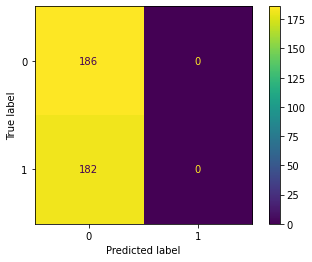

In [ ]:
NUM_SHADOW = 8
membership_attack()

In [ ]:
accuracy2.append(0.5054)
no_of_shadow_models2.append(8)

In [ ]:
accuracy2

[0.5054, 0.5869, 0.6331, 0.6114, 0.5054]

In [ ]:
no_of_shadow_models2

[4, 5, 6, 7, 8]

# Experimenting with other Attack Models

We have tried Linear SVM Model.

Now we will try other model architectures for the attack model:

1. Logistic Regression

2. Decision Tree Classifier

3. RBF Kernel SVM

In [ ]:
LEARNING_RATE = 0.001
EPOCH = 100
TRAINING_SIZE = 3000
TEST_SIZE = 2000
NUM_TARGET = 1
NUM_SHADOW = 6
IN = 1
OUT = 0
VERBOSE = 1

## 2. Logistic Regression Model as the Attack Model

In [ ]:
def get_trained_logistic_reg_models(train_data, test_data, num_models=1):
    
    from sklearn.linear_model import LogisticRegression
    
    (x_train, y_train), (x_test, y_test) = train_data, test_data
    models = []
    for i in range(num_models):

        print('Training Logistic Regression Model : ', i)
        models.append(LogisticRegression(random_state=0))
        models[i].fit(x_train[i], y_train[i])
        score = models[i].score(x_test[i],y_test[i])
        print('Logistic Regression Model ', i, 'score : ',score)

    return models

In [ ]:
def membership_attack_using_lr_attack():

  # load the pre-shuffled train and test data
  (x_train, y_train), (x_test, y_test) = load_fashion_mnsit_dataset()

  # split the data for each model
  target_train = (x_train[:TRAINING_SIZE*NUM_TARGET],y_train[:TRAINING_SIZE*NUM_TARGET])
  target_test = (x_test[:TEST_SIZE*NUM_TARGET],y_test[:TEST_SIZE*NUM_TARGET])
  target_train_data, target_test_data = sample_data(target_train, target_test, NUM_TARGET)

  shadow_train = (x_train[TRAINING_SIZE*NUM_TARGET:],y_train[TRAINING_SIZE*NUM_TARGET:])
  shadow_test = (x_test[TEST_SIZE*NUM_TARGET:],y_test[TEST_SIZE*NUM_TARGET:])
  shadow_train_data, shadow_test_data = sample_data(shadow_train, shadow_test, NUM_SHADOW)

  #cnn_model = build_fcnn_model()
  cnn_model = build_fcnn_model_fashion_mnist()
  
  # compile the target model
  target_models = get_trained_keras_models(cnn_model, target_train_data, target_test_data, NUM_TARGET)
  # compile the shadow models
  shadow_models = get_trained_keras_models(cnn_model, shadow_train_data, shadow_test_data, NUM_SHADOW)

  # get train data for the attack model
  attack_train = get_attack_dataset(shadow_models, shadow_train_data, shadow_test_data, NUM_SHADOW, TEST_SIZE)
  # get test data for the attack model
  attack_test = get_attack_dataset(target_models, target_train_data, target_test_data, NUM_TARGET, TEST_SIZE)

  # training the attack model
  attack_model = get_trained_logistic_reg_models(attack_train, attack_test)

  return attack_model

In [ ]:
lr_accuracy_scores=[]

In [ ]:
NUM_SHADOW=4
lr_attack = membership_attack_using_lr_attack()

Train: X=(60000, 28, 28), y=(60000,)
Test: X=(10000, 28, 28), y=(10000,)
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_4 (Flatten)         (None, 784)               0         
                                                                 
 dense_8 (Dense)             (None, 128)               100480    
                                                                 
 dense_9 (Dense)             (None, 10)                1290      
                                                                 
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


94/94 [==============================] - 1s 3ms/step - loss: 5.0950 - accuracy: 0.6193
Epoch 2/100
94/94 [==============================] - 0s 3ms/step - loss: 1.7186 - accuracy: 0.7483
Epoch 3/100
94/94 [==============================] - 0s 3ms/step - loss: 1.1787 - accuracy: 0.7843
Epoch 4/100
94/94 [==============================] - 0s 3ms/step - loss: 0.8325 - accuracy: 0.8150
Epoch 5/100
94/94 [==============================] - 0s 3ms/step - loss: 0.7103 - accuracy: 0.8303
Epoch 6/100
94/94 [==============================] - 0s 3ms/step - loss: 0.5520 - accuracy: 0.8343
Epoch 7/100
94/94 [==============================] - 0s 3ms/step - loss: 0.4683 - accuracy: 0.8497
Epoch 8/100
94/94 [==============================] - 0s 3ms/step - loss: 0.4116 - accuracy: 0.8583
Epoch 9/100
94/94 [==============================] - 0s 3ms/step - loss: 0.3344 - accuracy: 0.8590
Epoch 10/100
94/94 [==============================] - 0s 3ms/step - loss: 0.2855 - accuracy: 0.8763
Epoch 11/100
94/94 [=

In [ ]:
lr_accuracy_scores.append(0.6451)

In [ ]:
NUM_SHADOW=5
lr_attack = membership_attack_using_lr_attack()

Train: X=(60000, 28, 28), y=(60000,)
Test: X=(10000, 28, 28), y=(10000,)
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 784)               0         
                                                                 
 dense_2 (Dense)             (None, 128)               100480    
                                                                 
 dense_3 (Dense)             (None, 10)                1290      
                                                                 
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


94/94 [==============================] - 1s 4ms/step - loss: 5.6870 - accuracy: 0.6137
Epoch 2/100
94/94 [==============================] - 0s 4ms/step - loss: 1.9405 - accuracy: 0.7337
Epoch 3/100
94/94 [==============================] - 0s 3ms/step - loss: 1.2399 - accuracy: 0.7773
Epoch 4/100
94/94 [==============================] - 0s 4ms/step - loss: 0.8294 - accuracy: 0.8103
Epoch 5/100
94/94 [==============================] - 0s 4ms/step - loss: 0.5448 - accuracy: 0.8107
Epoch 6/100
94/94 [==============================] - 0s 3ms/step - loss: 0.3406 - accuracy: 0.8147
Epoch 7/100
94/94 [==============================] - 0s 4ms/step - loss: 0.2499 - accuracy: 0.7970
Epoch 8/100
94/94 [==============================] - 0s 3ms/step - loss: 0.1866 - accuracy: 0.8030
Epoch 9/100
94/94 [==============================] - 0s 3ms/step - loss: 0.1557 - accuracy: 0.8090
Epoch 10/100
94/94 [==============================] - 0s 3ms/step - loss: 0.1425 - accuracy: 0.8213
Epoch 11/100
94/94 [=

In [ ]:
lr_accuracy_scores.append(0.6021)

In [ ]:
NUM_SHADOW=6
lr_attack = membership_attack_using_lr_attack()

Train: X=(60000, 28, 28), y=(60000,)
Test: X=(10000, 28, 28), y=(10000,)
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 784)               0         
                                                                 
 dense_4 (Dense)             (None, 128)               100480    
                                                                 
 dense_5 (Dense)             (None, 10)                1290      
                                                                 
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


94/94 [==============================] - 1s 4ms/step - loss: 5.0781 - accuracy: 0.6077
Epoch 2/100
94/94 [==============================] - 0s 3ms/step - loss: 1.6637 - accuracy: 0.7337
Epoch 3/100
94/94 [==============================] - 0s 3ms/step - loss: 1.1305 - accuracy: 0.7870
Epoch 4/100
94/94 [==============================] - 0s 4ms/step - loss: 0.8426 - accuracy: 0.8100
Epoch 5/100
94/94 [==============================] - 0s 3ms/step - loss: 0.6838 - accuracy: 0.8233
Epoch 6/100
94/94 [==============================] - 0s 4ms/step - loss: 0.5883 - accuracy: 0.8373
Epoch 7/100
94/94 [==============================] - 0s 3ms/step - loss: 0.4977 - accuracy: 0.8497
Epoch 8/100
94/94 [==============================] - 0s 3ms/step - loss: 0.3425 - accuracy: 0.8670
Epoch 9/100
94/94 [==============================] - 0s 3ms/step - loss: 0.3088 - accuracy: 0.8710
Epoch 10/100
94/94 [==============================] - 0s 3ms/step - loss: 0.2674 - accuracy: 0.8737
Epoch 11/100
94/94 [=

In [ ]:
lr_accuracy_scores.append(0.6102)

In [ ]:
NUM_SHADOW=7
lr_attack = membership_attack_using_lr_attack()

Train: X=(60000, 28, 28), y=(60000,)
Test: X=(10000, 28, 28), y=(10000,)
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_3 (Flatten)         (None, 784)               0         
                                                                 
 dense_6 (Dense)             (None, 128)               100480    
                                                                 
 dense_7 (Dense)             (None, 10)                1290      
                                                                 
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


94/94 [==============================] - 1s 3ms/step - loss: 4.4063 - accuracy: 0.6293
Epoch 2/100
94/94 [==============================] - 0s 3ms/step - loss: 1.2801 - accuracy: 0.7373
Epoch 3/100
94/94 [==============================] - 0s 4ms/step - loss: 0.7113 - accuracy: 0.7593
Epoch 4/100
94/94 [==============================] - 0s 3ms/step - loss: 0.4869 - accuracy: 0.7780
Epoch 5/100
94/94 [==============================] - 0s 3ms/step - loss: 0.3826 - accuracy: 0.8010
Epoch 6/100
94/94 [==============================] - 0s 3ms/step - loss: 0.2867 - accuracy: 0.8107
Epoch 7/100
94/94 [==============================] - 0s 3ms/step - loss: 0.2257 - accuracy: 0.8230
Epoch 8/100
94/94 [==============================] - 0s 3ms/step - loss: 0.1868 - accuracy: 0.8230
Epoch 9/100
94/94 [==============================] - 0s 3ms/step - loss: 0.1493 - accuracy: 0.8433
Epoch 10/100
94/94 [==============================] - 0s 3ms/step - loss: 0.1346 - accuracy: 0.8410
Epoch 11/100
94/94 [=

In [ ]:
lr_accuracy_scores.append(0.6451)

## 3. RBF Kernel SVM as the Attack Model

In [ ]:
def get_trained_svm_rbf_models(train_data, test_data, num_models=1):

    from sklearn.metrics import precision_score, recall_score
    
    #Import svm model
    from sklearn import svm

    #Create a svm Classifier
    svm_rbf = svm.SVC(kernel='rbf', random_state=0,gamma='scale') # RBF Kernel SVM

    
    (x_train, y_train), (x_test, y_test) = train_data, test_data
    models = []
    for i in range(num_models):

        print('Training RBF Kernal SVM Model : ', i)
        models.append(svm_rbf)
        models[i].fit(x_train[i], y_train[i])
        score = models[i].score(x_test[i],y_test[i])
        print('RBF Kernel SVM Model ', i, 'score : ',score)
        #plot_confusion_matrix(models[i], x_test[i], y_test[i])  
        #plt.show()
        
        y_pred = models[i].predict(x_test[i])
        precision=precision_score(y_test[i], y_pred, average=None)
        print(precision) 
        recall = recall_score(y_test[i], y_pred, average=None)
        print(recall)

    return models

In [ ]:
def membership_attack_using_kernelSVM_attackModel():

  # load the pre-shuffled train and test data
  (x_train, y_train), (x_test, y_test) = load_fashion_mnsit_dataset()

  # split the data for each model
  target_train = (x_train[:TRAINING_SIZE*NUM_TARGET],y_train[:TRAINING_SIZE*NUM_TARGET])
  target_test = (x_test[:TEST_SIZE*NUM_TARGET],y_test[:TEST_SIZE*NUM_TARGET])
  target_train_data, target_test_data = sample_data(target_train, target_test, NUM_TARGET)

  shadow_train = (x_train[TRAINING_SIZE*NUM_TARGET:],y_train[TRAINING_SIZE*NUM_TARGET:])
  shadow_test = (x_test[TEST_SIZE*NUM_TARGET:],y_test[TEST_SIZE*NUM_TARGET:])
  shadow_train_data, shadow_test_data = sample_data(shadow_train, shadow_test, NUM_SHADOW)

  #cnn_model = build_fcnn_model()
  cnn_model = build_fcnn_model_fashion_mnist()
  
  # compile the target model
  target_models = get_trained_keras_models(cnn_model, target_train_data, target_test_data, NUM_TARGET)
  # compile the shadow models
  shadow_models = get_trained_keras_models(cnn_model, shadow_train_data, shadow_test_data, NUM_SHADOW)

  # get train data for the attack model
  attack_train = get_attack_dataset(shadow_models, shadow_train_data, shadow_test_data, NUM_SHADOW, TEST_SIZE)
  # get test data for the attack model
  attack_test = get_attack_dataset(target_models, target_train_data, target_test_data, NUM_TARGET, TEST_SIZE)

  # training the attack model
  attack_model = get_trained_svm_rbf_models(attack_train, attack_test)

  return attack_model

In [ ]:
rbf_svm_accuracy_scores=[]

In [ ]:
NUM_SHADOW=4
rbf_kernel_attack = membership_attack_using_kernelSVM_attackModel()

Train: X=(60000, 28, 28), y=(60000,)
Test: X=(10000, 28, 28), y=(10000,)
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_5 (Flatten)         (None, 784)               0         
                                                                 
 dense_10 (Dense)            (None, 128)               100480    
                                                                 
 dense_11 (Dense)            (None, 10)                1290      
                                                                 
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


94/94 [==============================] - 1s 3ms/step - loss: 4.6203 - accuracy: 0.6250
Epoch 2/100
94/94 [==============================] - 0s 3ms/step - loss: 1.5305 - accuracy: 0.7497
Epoch 3/100
94/94 [==============================] - 0s 3ms/step - loss: 0.8615 - accuracy: 0.7713
Epoch 4/100
94/94 [==============================] - 0s 3ms/step - loss: 0.5369 - accuracy: 0.8027
Epoch 5/100
94/94 [==============================] - 0s 3ms/step - loss: 0.4290 - accuracy: 0.8193
Epoch 6/100
94/94 [==============================] - 0s 3ms/step - loss: 0.3729 - accuracy: 0.8283
Epoch 7/100
94/94 [==============================] - 0s 3ms/step - loss: 0.2699 - accuracy: 0.8407
Epoch 8/100
94/94 [==============================] - 0s 3ms/step - loss: 0.2387 - accuracy: 0.8453
Epoch 9/100
94/94 [==============================] - 0s 3ms/step - loss: 0.1927 - accuracy: 0.8613
Epoch 10/100
94/94 [==============================] - 0s 3ms/step - loss: 0.1871 - accuracy: 0.8723
Epoch 11/100
94/94 [=

In [ ]:
rbf_svm_accuracy_scores.append(0.6263)

In [ ]:
NUM_SHADOW=5
rbf_kernel_attack = membership_attack_using_kernelSVM_attackModel()


Train: X=(60000, 28, 28), y=(60000,)
Test: X=(10000, 28, 28), y=(10000,)
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_6 (Flatten)         (None, 784)               0         
                                                                 
 dense_12 (Dense)            (None, 128)               100480    
                                                                 
 dense_13 (Dense)            (None, 10)                1290      
                                                                 
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


94/94 [==============================] - 1s 4ms/step - loss: 5.9299 - accuracy: 0.6010
Epoch 2/100
94/94 [==============================] - 0s 3ms/step - loss: 1.7466 - accuracy: 0.7323
Epoch 3/100
94/94 [==============================] - 0s 3ms/step - loss: 0.9475 - accuracy: 0.7763
Epoch 4/100
94/94 [==============================] - 0s 3ms/step - loss: 0.8292 - accuracy: 0.8040
Epoch 5/100
94/94 [==============================] - 0s 3ms/step - loss: 0.5892 - accuracy: 0.8263
Epoch 6/100
94/94 [==============================] - 0s 3ms/step - loss: 0.4959 - accuracy: 0.8390
Epoch 7/100
94/94 [==============================] - 0s 3ms/step - loss: 0.3841 - accuracy: 0.8500
Epoch 8/100
94/94 [==============================] - 0s 3ms/step - loss: 0.3043 - accuracy: 0.8703
Epoch 9/100
94/94 [==============================] - 0s 3ms/step - loss: 0.2318 - accuracy: 0.8723
Epoch 10/100
94/94 [==============================] - 0s 3ms/step - loss: 0.2264 - accuracy: 0.8783
Epoch 11/100
94/94 [=

In [ ]:
rbf_svm_accuracy_scores.append(0.6102)

In [ ]:
NUM_SHADOW=6
rbf_kernel_attack = membership_attack_using_kernelSVM_attackModel()

Train: X=(60000, 28, 28), y=(60000,)
Test: X=(10000, 28, 28), y=(10000,)
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_7 (Flatten)         (None, 784)               0         
                                                                 
 dense_14 (Dense)            (None, 128)               100480    
                                                                 
 dense_15 (Dense)            (None, 10)                1290      
                                                                 
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


94/94 [==============================] - 1s 3ms/step - loss: 5.2939 - accuracy: 0.6257
Epoch 2/100
94/94 [==============================] - 0s 3ms/step - loss: 1.8405 - accuracy: 0.7433
Epoch 3/100
94/94 [==============================] - 0s 3ms/step - loss: 1.3239 - accuracy: 0.7890
Epoch 4/100
94/94 [==============================] - 0s 4ms/step - loss: 1.0187 - accuracy: 0.8183
Epoch 5/100
94/94 [==============================] - 0s 4ms/step - loss: 0.7792 - accuracy: 0.8230
Epoch 6/100
94/94 [==============================] - 0s 4ms/step - loss: 0.5987 - accuracy: 0.8503
Epoch 7/100
94/94 [==============================] - 0s 3ms/step - loss: 0.5118 - accuracy: 0.8497
Epoch 8/100
94/94 [==============================] - 0s 3ms/step - loss: 0.4530 - accuracy: 0.8610
Epoch 9/100
94/94 [==============================] - 0s 4ms/step - loss: 0.3543 - accuracy: 0.8760
Epoch 10/100
94/94 [==============================] - 0s 3ms/step - loss: 0.3277 - accuracy: 0.8660
Epoch 11/100
94/94 [=

In [ ]:
rbf_svm_accuracy_scores.append(0.6720)

In [ ]:
NUM_SHADOW=7
rbf_kernel_attack = membership_attack_using_kernelSVM_attackModel()

Train: X=(60000, 28, 28), y=(60000,)
Test: X=(10000, 28, 28), y=(10000,)
Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_8 (Flatten)         (None, 784)               0         
                                                                 
 dense_16 (Dense)            (None, 128)               100480    
                                                                 
 dense_17 (Dense)            (None, 10)                1290      
                                                                 
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


94/94 [==============================] - 1s 3ms/step - loss: 5.5290 - accuracy: 0.6077
Epoch 2/100
94/94 [==============================] - 0s 3ms/step - loss: 2.0254 - accuracy: 0.7433
Epoch 3/100
94/94 [==============================] - 0s 3ms/step - loss: 1.3134 - accuracy: 0.7823
Epoch 4/100
94/94 [==============================] - 0s 4ms/step - loss: 0.8779 - accuracy: 0.8067
Epoch 5/100
94/94 [==============================] - 0s 3ms/step - loss: 0.7187 - accuracy: 0.8220
Epoch 6/100
94/94 [==============================] - 0s 3ms/step - loss: 0.5893 - accuracy: 0.8393
Epoch 7/100
94/94 [==============================] - 0s 3ms/step - loss: 0.4784 - accuracy: 0.8563
Epoch 8/100
94/94 [==============================] - 0s 3ms/step - loss: 0.4389 - accuracy: 0.8657
Epoch 9/100
94/94 [==============================] - 0s 3ms/step - loss: 0.3382 - accuracy: 0.8770
Epoch 10/100
94/94 [==============================] - 0s 3ms/step - loss: 0.2793 - accuracy: 0.8763
Epoch 11/100
94/94 [=

In [ ]:
rbf_svm_accuracy_scores.append(0.6290)

## 4. Decision Tree as the Attack Model

In [ ]:
def get_trained_decision_tree_models(train_data, test_data, num_models=1):
    
    from sklearn.tree import DecisionTreeClassifier
    
    (x_train, y_train), (x_test, y_test) = train_data, test_data
    models = []
    for i in range(num_models):

        print('Training Decision Tree Classifier Model : ', i)
        models.append(DecisionTreeClassifier(random_state=0))
        models[i].fit(x_train[i], y_train[i])
        score = models[i].score(x_test[i],y_test[i])
        print('Decision Tree Model ', i, 'score : ',score)

    return models

In [ ]:
def membership_attack_using_decision_tree_attack():

  # load the pre-shuffled train and test data
  (x_train, y_train), (x_test, y_test) = load_fashion_mnsit_dataset()

  # split the data for each model
  target_train = (x_train[:TRAINING_SIZE*NUM_TARGET],y_train[:TRAINING_SIZE*NUM_TARGET])
  target_test = (x_test[:TEST_SIZE*NUM_TARGET],y_test[:TEST_SIZE*NUM_TARGET])
  target_train_data, target_test_data = sample_data(target_train, target_test, NUM_TARGET)

  shadow_train = (x_train[TRAINING_SIZE*NUM_TARGET:],y_train[TRAINING_SIZE*NUM_TARGET:])
  shadow_test = (x_test[TEST_SIZE*NUM_TARGET:],y_test[TEST_SIZE*NUM_TARGET:])
  shadow_train_data, shadow_test_data = sample_data(shadow_train, shadow_test, NUM_SHADOW)

  #cnn_model = build_fcnn_model()
  cnn_model = build_fcnn_model_fashion_mnist()
  

  # compile the target model
  target_models = get_trained_keras_models(cnn_model, target_train_data, target_test_data, NUM_TARGET)
  # compile the shadow models
  shadow_models = get_trained_keras_models(cnn_model, shadow_train_data, shadow_test_data, NUM_SHADOW)

  # get train data for the attack model
  attack_train = get_attack_dataset(shadow_models, shadow_train_data, shadow_test_data, NUM_SHADOW, TEST_SIZE)
  # get test data for the attack model
  attack_test = get_attack_dataset(target_models, target_train_data, target_test_data, NUM_TARGET, TEST_SIZE)

  # training the attack model
  attack_model = get_trained_decision_tree_models(attack_train, attack_test)

  return attack_model


In [ ]:
dt_accuracy_scores=[]

In [ ]:
NUM_SHADOW=4
dt_attack = membership_attack_using_decision_tree_attack()

Train: X=(60000, 28, 28), y=(60000,)
Test: X=(10000, 28, 28), y=(10000,)
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_6 (Flatten)         (None, 784)               0         
                                                                 
 dense_12 (Dense)            (None, 128)               100480    
                                                                 
 dense_13 (Dense)            (None, 10)                1290      
                                                                 
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


94/94 [==============================] - 1s 3ms/step - loss: 5.8386 - accuracy: 0.5920
Epoch 2/100
94/94 [==============================] - 0s 3ms/step - loss: 1.9167 - accuracy: 0.7270
Epoch 3/100
94/94 [==============================] - 0s 3ms/step - loss: 1.2159 - accuracy: 0.7783
Epoch 4/100
94/94 [==============================] - 0s 3ms/step - loss: 0.8454 - accuracy: 0.7970
Epoch 5/100
94/94 [==============================] - 0s 3ms/step - loss: 0.6484 - accuracy: 0.8223
Epoch 6/100
94/94 [==============================] - 0s 3ms/step - loss: 0.5309 - accuracy: 0.8447
Epoch 7/100
94/94 [==============================] - 0s 3ms/step - loss: 0.4250 - accuracy: 0.8513
Epoch 8/100
94/94 [==============================] - 0s 3ms/step - loss: 0.3554 - accuracy: 0.8497
Epoch 9/100
94/94 [==============================] - 0s 3ms/step - loss: 0.2752 - accuracy: 0.8660
Epoch 10/100
94/94 [==============================] - 0s 3ms/step - loss: 0.2402 - accuracy: 0.8707
Epoch 11/100
94/94 [=

In [ ]:
dt_accuracy_scores.append(0.6397)

In [ ]:
NUM_SHADOW=5
dt_attack = membership_attack_using_decision_tree_attack()

Train: X=(60000, 28, 28), y=(60000,)
Test: X=(10000, 28, 28), y=(10000,)
Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_8 (Flatten)         (None, 784)               0         
                                                                 
 dense_16 (Dense)            (None, 128)               100480    
                                                                 
 dense_17 (Dense)            (None, 10)                1290      
                                                                 
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


94/94 [==============================] - 1s 3ms/step - loss: 5.3092 - accuracy: 0.6080
Epoch 2/100
94/94 [==============================] - 0s 3ms/step - loss: 1.8304 - accuracy: 0.7437
Epoch 3/100
94/94 [==============================] - 0s 3ms/step - loss: 1.2409 - accuracy: 0.7773
Epoch 4/100
94/94 [==============================] - 0s 3ms/step - loss: 0.9240 - accuracy: 0.7960
Epoch 5/100
94/94 [==============================] - 0s 3ms/step - loss: 0.7763 - accuracy: 0.8263
Epoch 6/100
94/94 [==============================] - 0s 3ms/step - loss: 0.6080 - accuracy: 0.8340
Epoch 7/100
94/94 [==============================] - 0s 3ms/step - loss: 0.5294 - accuracy: 0.8527
Epoch 8/100
94/94 [==============================] - 0s 3ms/step - loss: 0.4561 - accuracy: 0.8610
Epoch 9/100
94/94 [==============================] - 0s 3ms/step - loss: 0.4758 - accuracy: 0.8683
Epoch 10/100
94/94 [==============================] - 0s 3ms/step - loss: 0.3398 - accuracy: 0.8807
Epoch 11/100
94/94 [=

In [ ]:
dt_accuracy_scores.append(0.6182)

In [ ]:
NUM_SHADOW=6
dt_attack = membership_attack_using_decision_tree_attack()

Train: X=(60000, 28, 28), y=(60000,)
Test: X=(10000, 28, 28), y=(10000,)
Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_9 (Flatten)         (None, 784)               0         
                                                                 
 dense_18 (Dense)            (None, 128)               100480    
                                                                 
 dense_19 (Dense)            (None, 10)                1290      
                                                                 
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


94/94 [==============================] - 1s 3ms/step - loss: 5.1743 - accuracy: 0.5907
Epoch 2/100
94/94 [==============================] - 0s 3ms/step - loss: 1.5756 - accuracy: 0.7343
Epoch 3/100
94/94 [==============================] - 0s 3ms/step - loss: 1.0058 - accuracy: 0.7893
Epoch 4/100
94/94 [==============================] - 0s 4ms/step - loss: 0.7405 - accuracy: 0.8110
Epoch 5/100
94/94 [==============================] - 0s 4ms/step - loss: 0.5450 - accuracy: 0.8377
Epoch 6/100
94/94 [==============================] - 0s 3ms/step - loss: 0.5142 - accuracy: 0.8407
Epoch 7/100
94/94 [==============================] - 0s 3ms/step - loss: 0.4045 - accuracy: 0.8563
Epoch 8/100
94/94 [==============================] - 0s 3ms/step - loss: 0.3294 - accuracy: 0.8713
Epoch 9/100
94/94 [==============================] - 0s 3ms/step - loss: 0.2958 - accuracy: 0.8817
Epoch 10/100
94/94 [==============================] - 0s 3ms/step - loss: 0.2649 - accuracy: 0.8843
Epoch 11/100
94/94 [=

In [ ]:
dt_accuracy_scores.append(0.5860)

In [ ]:
NUM_SHADOW=7
dt_attack = membership_attack_using_decision_tree_attack()

Train: X=(60000, 28, 28), y=(60000,)
Test: X=(10000, 28, 28), y=(10000,)
Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_10 (Flatten)        (None, 784)               0         
                                                                 
 dense_20 (Dense)            (None, 128)               100480    
                                                                 
 dense_21 (Dense)            (None, 10)                1290      
                                                                 
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


94/94 [==============================] - 1s 3ms/step - loss: 5.6527 - accuracy: 0.6023
Epoch 2/100
94/94 [==============================] - 0s 3ms/step - loss: 2.0318 - accuracy: 0.7400
Epoch 3/100
94/94 [==============================] - 0s 3ms/step - loss: 1.1812 - accuracy: 0.7840
Epoch 4/100
94/94 [==============================] - 0s 3ms/step - loss: 0.8273 - accuracy: 0.8103
Epoch 5/100
94/94 [==============================] - 0s 3ms/step - loss: 0.6501 - accuracy: 0.8230
Epoch 6/100
94/94 [==============================] - 0s 3ms/step - loss: 0.5187 - accuracy: 0.8310
Epoch 7/100
94/94 [==============================] - 0s 3ms/step - loss: 0.4492 - accuracy: 0.8543
Epoch 8/100
94/94 [==============================] - 0s 3ms/step - loss: 0.3662 - accuracy: 0.8587
Epoch 9/100
94/94 [==============================] - 0s 3ms/step - loss: 0.3288 - accuracy: 0.8637
Epoch 10/100
94/94 [==============================] - 0s 3ms/step - loss: 0.3361 - accuracy: 0.8607
Epoch 11/100
94/94 [=

In [ ]:
dt_accuracy_scores.append(0.6370)

Here are the accuracy scores we got for all the attack models:

In [ ]:
lr_accuracy_scores

[0.6451, 0.6021, 0.6102, 0.6451]

In [ ]:
linear_svm_accuracy_scores

[0.6021, 0.5913, 0.637, 0.6129]

In [ ]:
rbf_svm_accuracy_scores

[0.6263, 0.6102, 0.672, 0.629]

In [ ]:
dt_accuracy_scores

[0.6397, 0.6182, 0.586, 0.637]

In [ ]:
from statistics import mean

mean_lr_accuracy = mean(lr_accuracy_scores)
print("Mean Logistic Regression Attack Accuracy:", mean_lr_accuracy)
mean_linear_svm_accuracy = mean(linear_svm_accuracy_scores)
print("Mean Linear SVM Attack Accuracy:", mean_linear_svm_accuracy)
mean_rbf_accuracy = mean(rbf_svm_accuracy_scores)
print("Mean RBF Kernel SVM Attack Accuracy:", mean_rbf_accuracy)
mean_dt_accuracy = mean(dt_accuracy_scores)
print("Mean Decision Tree Attack Accuracy:", mean_dt_accuracy)

Mean Logistic Regression Attack Accuracy: 0.625625
Mean Linear SVM Attack Accuracy: 0.610825
Mean RBF Kernel SVM Attack Accuracy: 0.634375
Mean Decision Tree Attack Accuracy: 0.620225


## Best Performing Attack Model: Linear SVM with 6 Shadow Models

In [ ]:
def get_trained_svm_models(train_data, test_data, num_models=1):
    
    from sklearn.metrics import precision_score, recall_score
    
    from sklearn import svm
    (x_train, y_train), (x_test, y_test) = train_data, test_data
    models = []
    for i in range(num_models):
        print('Training svm model : ', i)
        models.append(svm.SVC(gamma='scale',kernel='linear',verbose=VERBOSE))
        models[i].fit(x_train[i], y_train[i])
        score = models[i].score(x_test[i],y_test[i])
        print('SVM model ', i, 'score : ',score)
        #plot_confusion_matrix(models[i], x_test[i], y_test[i])  
        #plt.show()

        y_pred = models[i].predict(x_test[i])
        precision=precision_score(y_test[i], y_pred, average=None)
        print("Precision Vector:",precision) 
        recall = recall_score(y_test[i], y_pred, average=None)
        print("Recall Vector:",recall)


    return models

In [ ]:
NUM_SHADOW=6
linear_svm_attack = membership_attack()

Train: X=(60000, 28, 28), y=(60000,)
Test: X=(10000, 28, 28), y=(10000,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 128)               100480    
                                                                 
 dense_1 (Dense)             (None, 10)                1290      
                                                                 
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


Epoch 1/100
94/94 [==============================] - 1s 3ms/step - loss: 5.5700 - accuracy: 0.6017
Epoch 2/100
94/94 [==============================] - 0s 4ms/step - loss: 1.4466 - accuracy: 0.7400
Epoch 3/100
94/94 [==============================] - 0s 3ms/step - loss: 1.0452 - accuracy: 0.7780
Epoch 4/100
94/94 [==============================] - 0s 3ms/step - loss: 0.8094 - accuracy: 0.8000
Epoch 5/100
94/94 [==============================] - 0s 3ms/step - loss: 0.6907 - accuracy: 0.8200
Epoch 6/100
94/94 [==============================] - 0s 3ms/step - loss: 0.5736 - accuracy: 0.8303
Epoch 7/100
94/94 [==============================] - 0s 3ms/step - loss: 0.4336 - accuracy: 0.8547
Epoch 8/100
94/94 [==============================] - 0s 4ms/step - loss: 0.3672 - accuracy: 0.8623
Epoch 9/100
94/94 [==============================] - 0s 4ms/step - loss: 0.2762 - accuracy: 0.8750
Epoch 10/100
94/94 [==============================] - 0s 3ms/step - loss: 0.2290 - accuracy: 0.8743
Epoch 11/

Best Performing Model Accuracy: 0.6962

Best Performing Model Precision: 0.6237

Best Performing Model Recall: 0.9892